# Load Raw Data And Plot Left-Right curves and Reaction Time per transformation and difficulty
This script loads the database of the experiments described in
**"Response to Affine Transforms of Image Distance Metrics and Humans"**.

Then, it plots the relationship between the stimulus degree of distortion and the reaction time (RT) .

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D


---
Load and process data
---

In [39]:
url = 'https://raw.githubusercontent.com/paudauo/BBDD_Affine_Transformations/refs/heads/main/answers.csv'
df = pd.read_csv(url, header=0)

df = df[df['reaction_time_ms'] < 35000]

v_trans = df['transformation'].unique()
df['transformation'] = df['transformation'].astype('category')

df['D1'] = abs(df['distortion_level_11'] - df['distortion_level_12'])
df['D2'] = abs(df['distortion_level_21'] - df['distortion_level_22'])
df['c1'] = np.sign(df['D1'] - df['D2'])
df['c2'] = df['D1'] - df['D2']
df['c2F'] = df['c2'].astype('category')

df['ok'] = 0
df.loc[df['c1'] == 0, 'ok'] = 0
df.loc[(df['answer'] == 2) & (df['c1'] == -1), 'ok'] = 1
df.loc[(df['answer'] == 1) & (df['c1'] == 1), 'ok'] = 1
df.loc[(df['answer'] == 1) & (df['c1'] == -1), 'ok'] = -1
df.loc[(df['answer'] == 2) & (df['c1'] == 1), 'ok'] = -1

## Helper function

In [40]:
def percent_ok(df, transformation):
    # Filter the dataframe
    df = df.loc[df['transformation'] == transformation, :]
    # print(df['answer'].value_counts().sort_index())

    t1 = pd.crosstab(df['answer'], df['c1'], dropna=False)
    t2 = pd.crosstab(df['answer'], df['c2'], dropna=False)

    # Normalize to percentages
    sumt1 = t1.sum(axis=0)
    sumt2 = t2.sum(axis=0)

    t1_norm = pd.DataFrame(index=t1.index, columns=t1.columns, dtype=float)
    t2_norm = pd.DataFrame(index=t2.index, columns=t2.columns, dtype=float)

    for i in range(t2.shape[1]):
        if i < 3:  # first three columns only for t1
            t1_norm.iloc[:, i] = t1.iloc[:, i] / sumt1.iloc[i] * 100
        t2_norm.iloc[:, i] = t2.iloc[:, i] / sumt2.iloc[i] * 100

    t1_norm.index = ['%2Left', '%2Right'][:len(t1_norm)]
    t2_norm.index = ['%2Left', '%2Right'][:len(t2_norm)]

    return t2_norm

---
Plot figure 7a
---

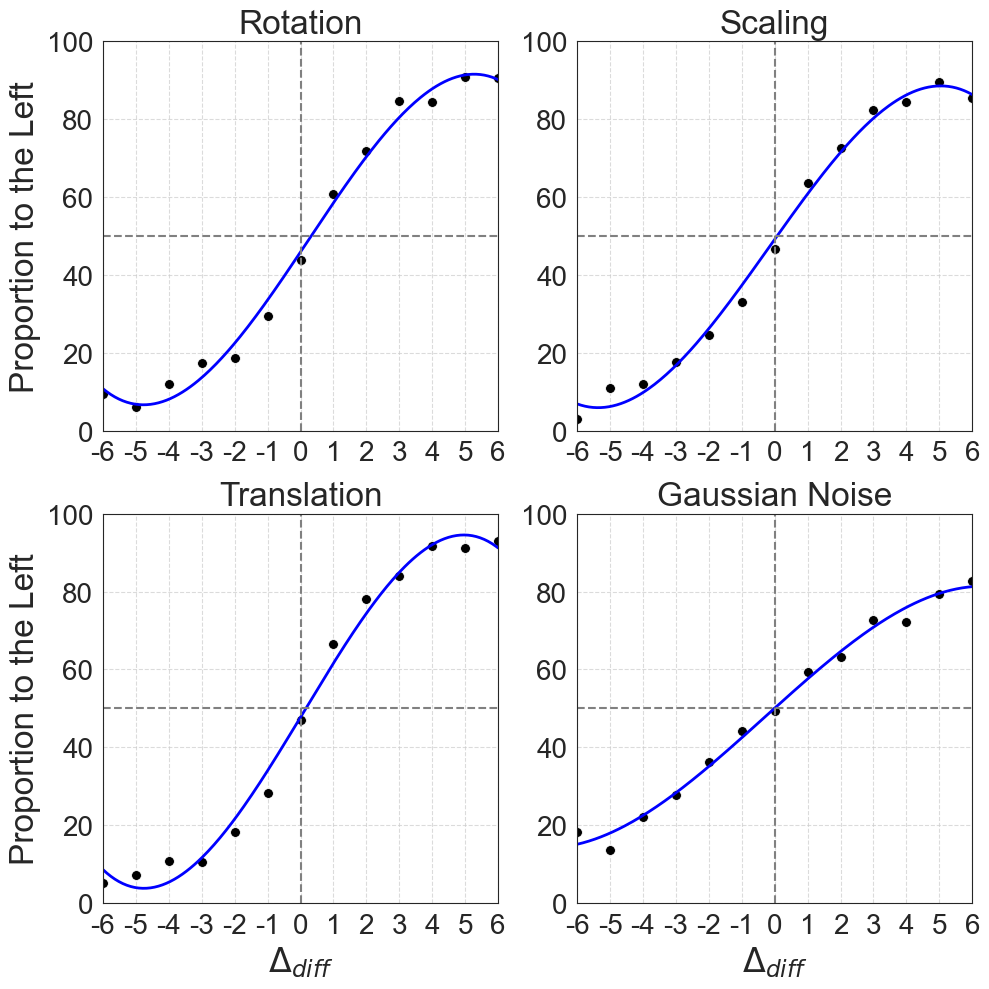

In [41]:
# Function to generate a subplot for a specific transformation
def plot_transformation(df, transformation, title, xlabel, ylabel):
    v_per_ok = percent_ok(df, transformation)
    v_diff = v_per_ok.columns.astype(int)
    n = len(v_diff)

    data_plot = pd.DataFrame({
        'Per': np.concatenate([v_per_ok.iloc[0].values, v_per_ok.iloc[1].values]),
        'Difference': np.concatenate([v_diff, v_diff]),
        'Side': ['%2Left'] * n + ['%2Right'] * n
    })

    data_plot2 = data_plot[data_plot['Side'] == '%2Left']

    # Polynomial fit
    # Choose degree of the polynomial, e.g., 2 for quadratic
    degree = 3
    x = data_plot2['Difference']
    y = data_plot2['Per']

    # Fit the polynomial
    coeffs = np.polyfit(x, y, degree)
    poly_eq = np.poly1d(coeffs)

    # Generate x values for plotting the smooth curve
    x_vals = np.linspace(x.min(), x.max(), 200)
    y_vals = poly_eq(x_vals)

    sns.set_style('white')
    ax = sns.scatterplot(data=data_plot2, x='Difference', y='Per', color='black', s=50)

    # Plot the polynomial curve
    ax.plot(x_vals, y_vals, color='blue', linewidth=2)

    ax.set_ylim(0, 100)
    ax.set_xlim(-6, 6)
    ax.axvline(0, color='gray', linestyle='--')
    ax.axhline(50, color='gray', linestyle='--')

    ax.set_title(title, fontsize=24)
    ax.set_xlabel(xlabel, fontsize=24)
    ax.set_ylabel(ylabel, fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    ax.set_xticks(np.arange(-6, 7, 1))
    ax.set_xticklabels(np.arange(-6, 7, 1), fontsize=20)
    ax.set_yticks(np.arange(0, 101, 20))
    ax.set_yticklabels(np.arange(0, 101, 20), fontsize=20)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_facecolor('white')
    return ax

# Set up the full figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Adjust spacing
plt.subplots_adjust(hspace=0.1, wspace=0.1)

# Each subplot
plt.sca(axs[0, 0])
plot_transformation(df, 'rotation', 'Rotation', '', 'Proportion to the Left')

plt.sca(axs[0, 1])
plot_transformation(df, 'scale', 'Scaling', '', '')

plt.sca(axs[1, 0])
plot_transformation(df, 'translation', 'Translation', r'$\Delta_{diff}$', 'Proportion to the Left')

plt.sca(axs[1, 1])
plot_transformation(df, 'gaussian_noise', 'Gaussian Noise', r'$\Delta_{diff}$', '')

plt.tight_layout()

---
Plot figure 7b
---

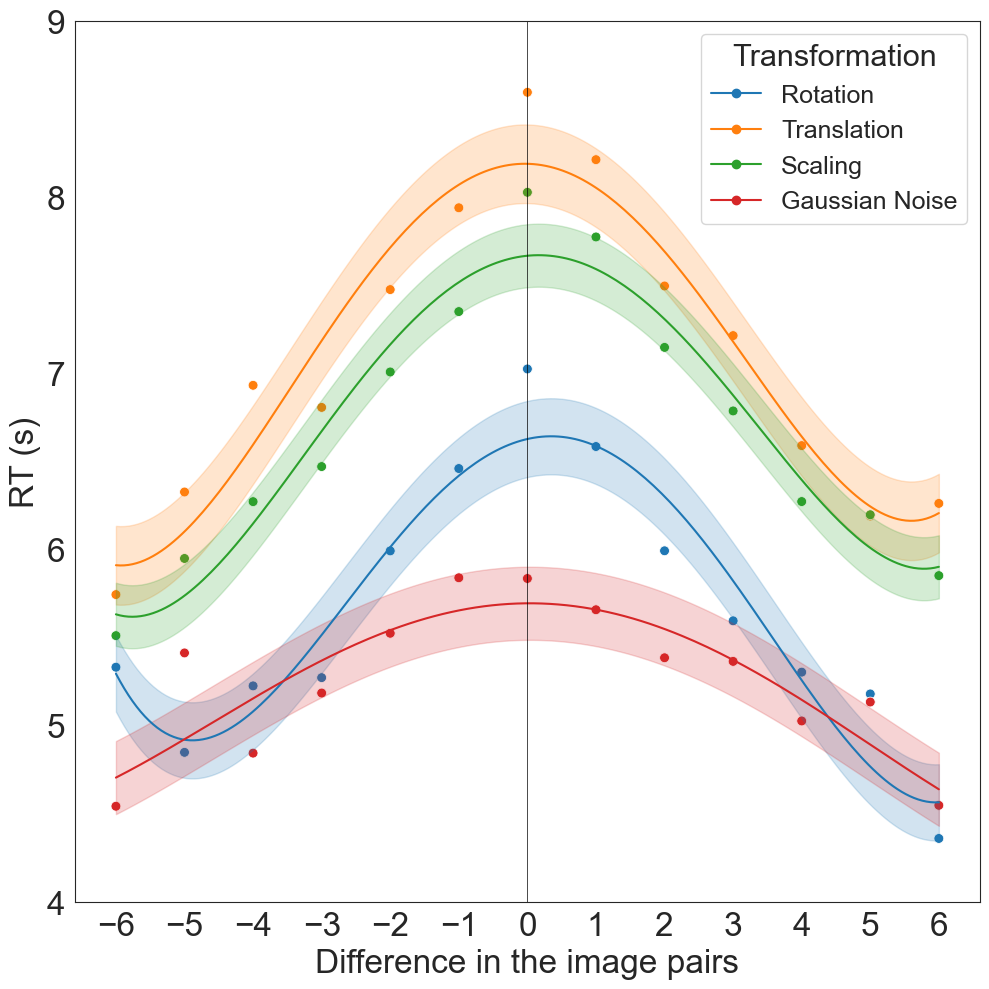

In [42]:
# Unique values for c2 and transformation
v_dif = sorted(df['c2'].unique())

# Initialize lists to store results
RT_mean, RT_meanF, RT_meanOk = [], [], []
RT_sd, RT_sd_ok, RT_sd_f = [], [], []
Trans, Dif = [], []

# Loop through unique values of Correct9 and transformation
for vdif in v_dif:
    for vtrans in df['transformation'].unique():
        index = (df['c2'] == vdif) & (df['transformation'] == vtrans)
        index1 = index & (df['ok'] >= 0)
        index2 = index & (df['ok'] < 0)

        RT_mean.append(df.loc[index, 'reaction_time_ms'].mean())
        RT_meanOk.append(df.loc[index1, 'reaction_time_ms'].mean())
        RT_meanF.append(df.loc[index2, 'reaction_time_ms'].mean())
        RT_sd.append(df.loc[index, 'reaction_time_ms'].std())
        RT_sd_ok.append(df.loc[index1, 'reaction_time_ms'].std())
        RT_sd_f.append(df.loc[index2, 'reaction_time_ms'].std())
        Trans.append(vtrans)
        Dif.append(vdif)

# Create a DataFrame
data = pd.DataFrame({
    'Difficulty': Dif,
    'RT': RT_mean,
    'RT_F': RT_meanF,
    'RT_Ok': RT_meanOk,
    'sd': RT_sd,
    'sd_ok': RT_sd_ok,
    'sd_F': RT_sd_f,
    'Transformation': Trans
})

# Rename transformation values
data['Transformation'] = data['Transformation'].replace({
    'scale': 'Scaling',
    'gaussian_noise': 'Gaussian Noise',
    'rotation': 'Rotation',
    'translation': 'Translation'
})

# Store custom legend handles
custom_handles = []

# Plot for "Solo ok"
plt.figure(figsize=(10, 10))
sns.scatterplot(data=data, x='Difficulty', y=data['RT_Ok'] / 1000, hue='Transformation', s=50)
for trans in data['Transformation'].unique():
    subset = data[data['Transformation'] == trans]
    x = subset['Difficulty']
    y = subset['RT_Ok'] / 1000

    # Fit a polynomial of degree 4
    coeffs = np.polyfit(x, y, 4)
    poly_eq = np.poly1d(coeffs)

    # Generate smooth x and y values for the curve
    x_vals = np.linspace(x.min(), x.max(), 200)
    y_vals = poly_eq(x_vals)

    # Calculate residuals and standard deviation
    residuals = y - poly_eq(x)
    std_dev = np.std(residuals)

    # Plot the polynomial curve
    line, = plt.plot(x_vals, y_vals, label=trans)

    # Add shaded region for standard deviation
    plt.fill_between(x_vals, y_vals - std_dev, y_vals + std_dev, alpha=0.2, color=line.get_color())

    custom_handles.append(Line2D([0], [0], color=line.get_color(), marker='o', linestyle='-', label=trans))

plt.xlabel('Difference in the image pairs', fontsize=24)
plt.ylabel('RT (s)', fontsize=24)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.ylim(4, 9)
plt.xticks(np.arange(-6, 7, 1), fontsize=24)
plt.yticks(np.arange(4, 10, 1), fontsize=24)
plt.grid(False)
plt.gca().set_facecolor('white')
plt.legend(handles=custom_handles, title='Transformation', fontsize=18, title_fontsize=22)

plt.tight_layout()